In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2

# Dataset Preparation

In [34]:
batch_size = 32
img_height = 180
img_width = 180

In [35]:
data_dir = '/content/drive/MyDrive/DataSet Playing Cards'

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 73 files belonging to 10 classes.
Using 59 files for training.


In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 73 files belonging to 10 classes.
Using 14 files for validation.


In [38]:
class_names = train_ds.class_names
print(class_names)

['Ace', 'Eight', 'Five', 'Four', 'Nine', 'Seven', 'Six', 'Ten', 'Three', 'Two']


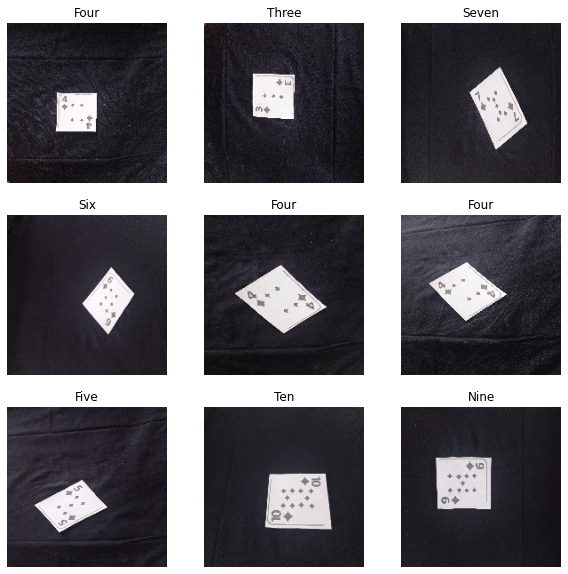

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [41]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0410477 0.97594696


# Model 1

In [43]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [46]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 [==============================] - 6s 5s/step - loss: 2.4106 - accuracy: 0.0847 - val_loss: 2.2523 - val_accuracy: 0.0714
Epoch 2/50
2/2 [==============================] - 2s 995ms/step - loss: 2.1948 - accuracy: 0.1356 - val_loss: 2.2253 - val_accuracy: 0.2143
Epoch 3/50
2/2 [==============================] - 2s 998ms/step - loss: 2.0290 - accuracy: 0.3559 - val_loss: 2.0847 - val_accuracy: 0.1429
Epoch 4/50
2/2 [==============================] - 2s 997ms/step - loss: 1.7294 - accuracy: 0.5932 - val_loss: 1.9175 - val_accuracy: 0.2143
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 1.3252 - accuracy: 0.6949 - val_loss: 1.8530 - val_accuracy: 0.3571
Epoch 6/50
2/2 [==============================] - 2s 907ms/step - loss: 1.0797 - accuracy: 0.7288 - val_loss: 1.9884 - val_accuracy: 0.5714
Epoch 7/50
2/2 [==============================] - 2s 1s/step - loss: 0.9149 - accuracy: 0.7119 - val_loss: 2.6079 - val_accuracy: 0.2857
Epoch 8/50
2/2 [========================

In [ ]:
model.save('model_1.h5')

In [48]:
class_to_value = {'Ace': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine': 9, 'Ten': 10}
test_folder_path = '/content/drive/MyDrive/DataSet Playing Cards/Nine/'
card_sum = 0
for filename in os.listdir(test_folder_path):
  img = tf.keras.utils.load_img(
      os.path.join(test_folder_path, filename), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = predictions[0]
  predicted_class = class_names[np.argmax(score)]
  predicted_value = class_to_value[predicted_class]
  card_sum += predicted_value
  accuracy = np.max(score) * 100
  print('predicted value is', predicted_value)
  print('accuracy', round(accuracy, 2))
  print('card sum is', card_sum)

predicted value is 9
accuracy 99.96
card sum is 9
predicted value is 9
accuracy 100.0
card sum is 18
predicted value is 10
accuracy 99.88
card sum is 28
predicted value is 9
accuracy 99.96
card sum is 37
predicted value is 9
accuracy 100.0
card sum is 46
predicted value is 9
accuracy 99.98
card sum is 55
predicted value is 8
accuracy 78.97
card sum is 63


# Model 2

In [49]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [50]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 [==============================] - 10s 5s/step - loss: 2.5844 - accuracy: 0.0847 - val_loss: 2.2107 - val_accuracy: 0.2143
Epoch 2/50
2/2 [==============================] - 8s 4s/step - loss: 2.3104 - accuracy: 0.1695 - val_loss: 2.2584 - val_accuracy: 0.3571
Epoch 3/50
2/2 [==============================] - 8s 4s/step - loss: 2.2813 - accuracy: 0.1864 - val_loss: 2.2494 - val_accuracy: 0.0714
Epoch 4/50
2/2 [==============================] - 8s 5s/step - loss: 2.2814 - accuracy: 0.1525 - val_loss: 2.2405 - val_accuracy: 0.1429
Epoch 5/50
2/2 [==============================] - 8s 5s/step - loss: 2.2289 - accuracy: 0.2034 - val_loss: 2.1807 - val_accuracy: 0.1429
Epoch 6/50
2/2 [==============================] - 8s 5s/step - loss: 2.1796 - accuracy: 0.2034 - val_loss: 2.0171 - val_accuracy: 0.3571
Epoch 7/50
2/2 [==============================] - 8s 5s/step - loss: 2.1137 - accuracy: 0.2542 - val_loss: 2.0401 - val_accuracy: 0.3571
Epoch 8/50
2/2 [==============================] - 8

In [ ]:
model.save('model_2.h5')

In [53]:
class_to_value = {'Ace': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine': 9, 'Ten': 10}
test_folder_path = '/content/drive/MyDrive/DataSet Playing Cards/Nine/'
card_sum = 0
for filename in os.listdir(test_folder_path):
  img = tf.keras.utils.load_img(
      os.path.join(test_folder_path, filename), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = predictions[0]
  predicted_class = class_names[np.argmax(score)]
  predicted_value = class_to_value[predicted_class]
  card_sum += predicted_value
  accuracy = np.max(score) * 100
  print('predicted value is', predicted_value)
  print('accuracy', round(accuracy, 2))
  print('card sum is', card_sum)

predicted value is 2
accuracy 88.36
card sum is 2
predicted value is 9
accuracy 84.18
card sum is 11
predicted value is 10
accuracy 53.54
card sum is 21
predicted value is 2
accuracy 59.54
card sum is 23
predicted value is 9
accuracy 79.75
card sum is 32
predicted value is 9
accuracy 70.86
card sum is 41
predicted value is 2
accuracy 66.26
card sum is 43


# Model 3

In [60]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [70]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))
base_model.trainable = False ## Not trainable weights
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                                 
 dense_22 (Dense)            (None, 64)                819264    
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 10)                330       
                                                                 
Total params: 15,536,362
Trainable params: 821,674
Non-trainable params: 14,714,688
_________________________________________________________________


In [71]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 [==============================] - 21s 12s/step - loss: 7.5266 - accuracy: 0.1186 - val_loss: 5.1858 - val_accuracy: 0.1429
Epoch 2/50
2/2 [==============================] - 21s 12s/step - loss: 4.1129 - accuracy: 0.1695 - val_loss: 3.0903 - val_accuracy: 0.1429
Epoch 3/50
2/2 [==============================] - 20s 11s/step - loss: 2.1660 - accuracy: 0.3559 - val_loss: 2.8550 - val_accuracy: 0.0714
Epoch 4/50
2/2 [==============================] - 20s 11s/step - loss: 1.2994 - accuracy: 0.5763 - val_loss: 2.5446 - val_accuracy: 0.1429
Epoch 5/50
2/2 [==============================] - 20s 11s/step - loss: 0.8930 - accuracy: 0.6780 - val_loss: 2.3415 - val_accuracy: 0.2143
Epoch 6/50
2/2 [==============================] - 20s 13s/step - loss: 0.7241 - accuracy: 0.7288 - val_loss: 2.4590 - val_accuracy: 0.3571
Epoch 7/50
2/2 [==============================] - 20s 13s/step - loss: 0.4560 - accuracy: 0.8136 - val_loss: 2.7416 - val_accuracy: 0.4286
Epoch 8/50
2/2 [======================

In [76]:
model.save('model_3.h5')

In [75]:
class_to_value = {'Ace': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine': 9, 'Ten': 10}
test_folder_path = '/content/drive/MyDrive/DataSet Playing Cards/Ten/'
card_sum = 0
for filename in os.listdir(test_folder_path):
  img = tf.keras.utils.load_img(
      os.path.join(test_folder_path, filename), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = predictions[0]
  predicted_class = class_names[np.argmax(score)]
  predicted_value = class_to_value[predicted_class]
  card_sum += predicted_value
  accuracy = np.max(score) * 100
  print('predicted value is', predicted_value)
  print('accuracy', round(accuracy, 2))
  print('card sum is', card_sum)

predicted value is 10
accuracy 99.96
card sum is 10
predicted value is 10
accuracy 77.18
card sum is 20
predicted value is 10
accuracy 99.77
card sum is 30
predicted value is 10
accuracy 99.6
card sum is 40
predicted value is 10
accuracy 72.18
card sum is 50
predicted value is 10
accuracy 99.69
card sum is 60
predicted value is 10
accuracy 99.91
card sum is 70
predicted value is 10
accuracy 99.87
card sum is 80
